## Test Epidemiology models for pyciemss

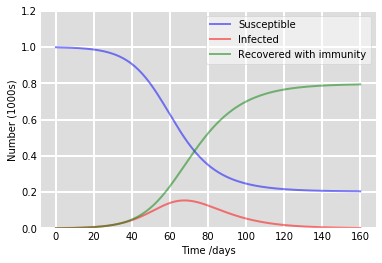

In [2]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

# Total population, N.
N = 1000.0
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1.0, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = scipy.integrate.odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [1]:
from torchdiffeq import odeint, odeint_adjoint, odeint_event
import torchdiffeq
import torch
import torch.nn as nn

class SIR(nn.Module):
    def __init__(self, params, initial_state, adjoint=False):
        super().__init__()
        self.N, self.beta, self.gamma = [nn.Parameter(torch.as_tensor(p)) for p in params]
        self.S0, self.I0, self.R0 = [nn.Parameter(torch.as_tensor(x0)) for x0 in initial_state]
        self.t0 = nn.Parameter(torch.tensor([0.0]))
        self.odeint = odeint_adjoint if adjoint else odeint
    
    def get_tspan(self, start, end, steps):
        return torch.linspace(float(start), float(end), steps)
        
    def forward(self, t, state):
        S, I, R = state
        dSdt = -self.beta * S * I / self.N
        dIdt = self.beta * S * I / self.N - self.gamma * I
        dRdt = self.gamma * I
        return dSdt, dIdt, dRdt
    
    def get_initial_state(self):
        return self.S0, self.I0, self.R0
    
    def get_params(self):
        return self.N, self.beta, self.gamma
    

In [3]:
sir = SIR((N, beta, gamma), (S0, I0, R0), adjoint=False)
solution = torchdiffeq.odeint(sir, sir.get_initial_state(), sir.get_tspan(0, 160, 160))
S, I, R = [s.detach().numpy() for s in solution]
N, beta, gamma = sir.get_params()

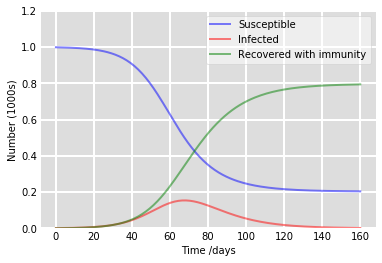

In [4]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [5]:
sir_adj = SIR((N, beta, gamma), (S0, I0, R0), adjoint=True)
solution = torchdiffeq.odeint(sir_adj, sir_adj.get_initial_state(), sir_adj.get_tspan(0, 160, 160))
S, I, R = [s.detach().numpy() for s in solution]
N, beta, gamma = sir_adj.get_params()

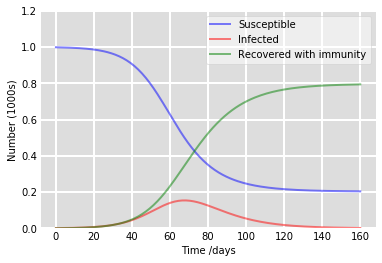

In [6]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Next step: compute gradients of solution with respect to initial conditions and parameters

## Final step:  Put model into pyro with observational noise and use SVI to solve inverse problem